In [10]:
import glob

output_file = 'solar_panel.csv'
header_saved = False

# Otwórz plik wyjściowy i przejdź przez wszystkie pliki csv
with open(output_file, 'w') as fout:
    for file in glob.glob('data/pv/**/*.csv', recursive=True):
        with open(file) as fin:
            # Dodaj nagłówek tylko raz, przed pierwszym plikiem danych
            header = next(fin)
            if not header_saved:
                data = header.split(',')
                
                if('\n' in data[1]):
                    fout.write(data[0] + ',' + data[1])
                else:
                    fout.write(data[0] + ',' + data[1] + '\n')

                header_saved = True

            # Skopiuj zawartość pliku csv do pliku wyjściowego
            for line in fin:
                data = line.split(',')
                if('\n' in data[1]):
                    fout.write(data[0] + ',' + data[1])
                else:
                    fout.write(data[0] + ',' + data[1] + '\n')


### Dostowanie danych pomiarowych produkcji paneli
* Wczytanie danych z pliku csv
* Podział kolumny zawierającej informacje o dacie na sześć osobnych składowych
* Posortowanie danych w kolejności czasowej

In [47]:
import pandas as pd

pv = pd.read_csv('solar_panel.csv')

pv[['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']] = pv['DateTime'].str.split('[- :]', expand=True)

pv['Date'] = pv.apply(lambda row: f"{row['Year']}-{row['Month']}-{row['Day']}", axis=1)

pv['Time'] = pv.apply(lambda row: f"{row['Hour']}:{row['Minute']}:{row['Second']}", axis=1)

pv.sort_values(by='DateTime', inplace=True)

pv = pv.rename(columns={'Moc chwilowa PV': 'PV_output'})

pv.head()

,DateTime,PV_output,Year,Month,Day,Hour,Minute,Second,Date,Time
33809,2022-01-01 09:01:15,0.001,2022,01,01,09,01,15,2022-01-01,09:01:15
33810,2022-01-01 09:05:03,0.316,2022,01,01,09,05,03,2022-01-01,09:05:03
33811,2022-01-01 09:10:03,0.108,2022,01,01,09,10,03,2022-01-01,09:10:03
33812,2022-01-01 09:17:27,0.170,2022,01,01,09,17,27,2022-01-01,09:17:27
33813,2022-01-01 09:20:04,0.000,2022,01,01,09,20,04,2022-01-01,09:20:04


### Zliczenie liczby próbek na godzinę
Pierwszym aspektem, który należy sprawdzić w badanym zbiorze danych to równomierność rozłożenia próbek odczytu produkcji paneli słonecznych w poszczególnych miesiącach.

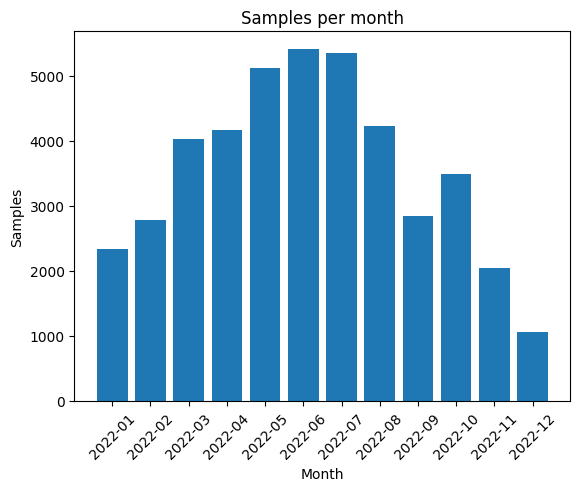

In [29]:

import matplotlib.pyplot as plt

per_month = pd.DataFrame(pv.groupby(['Year', 'Month']).size().reset_index(name='Count'))

per_month['Date'] = per_month.apply(lambda row: f"{row['Year']}-{row['Month']}", axis=1)

per_month.drop(['Year', 'Month'], axis=1, inplace=True)

per_month.head()

plt.bar(per_month['Date'], per_month['Count'])
plt.title('Samples per month')
plt.xlabel('Month')
plt.ylabel('Samples')
plt.tick_params(axis='x', labelrotation = 45)
plt.show()


### Produkcja na dzień

In [67]:
data = pv[['Date', 'Time']]

start_per_day = pd.DataFrame(data.groupby(['Date']).min().reset_index())
start_per_day['Time'] = pd.to_timedelta(start_per_day['Time'])

end_per_day = pd.DataFrame(data.groupby(['Date']).max().reset_index())
end_per_day['Time'] = pd.to_timedelta(end_per_day['Time'])

time_diff = end_per_day['Time'] - start_per_day['Time']

pv_timing = pd.DataFrame({'Date' : start_per_day['Date'], 'Start' : start_per_day['Time'], 'End' : end_per_day['Time'], 'Time': time_diff.dt.total_seconds() / 3600})

pv_timing.head()

,Date,Start,End,Time
0,2022-01-01,0 days 09:01:15,0 days 14:26:14,5.416389
1,2022-01-02,0 days 08:46:14,0 days 14:46:14,6.000000
2,2022-01-03,0 days 08:26:14,0 days 14:05:03,5.646944
3,2022-01-04,0 days 08:32:27,0 days 14:05:03,5.543333
4,2022-01-05,0 days 08:56:13,0 days 13:52:27,4.937222


In [69]:
per_day = pv[['PV_output', 'Year', 'Month', 'Day']]

per_day = pd.DataFrame(per_day.groupby(['Year', 'Month', 'Day']).mean().reset_index())

per_day['Time'] = pv_timing['Time']

per_day['Output'] = pv_timing['Time'] * per_day['PV_output']

per_day.head()

,Year,Month,Day,PV_output,Time,Output
0,2022,01,01,0.194600,5.416389,1.054029
1,2022,01,02,0.192352,6.000000,1.154113
2,2022,01,03,0.127509,5.646944,0.720035
3,2022,01,04,0.232470,5.543333,1.288657
4,2022,01,05,0.204696,4.937222,1.010632
